# Option 2: Geological Image Simalarity

## BACKGROUND
A geology research company wants to create a tool for identifying interesting patterns in their imagery data. This tool will possess a search capability whereby an analyst provides an image of interest and is presented with other images which are similar to it.
## GOAL
Your task is to create the machine learning component for this image similarity application. The machine learning
model should return the top K images that are most similar to this image based on a single image input.
## DATA
Link to data: https://www.kaggle.com/tanyadayanand/geological-image-similarity

In [1]:
#TODO
#1.  Filter out corrupted images
#2.  Image data augmentation
# ! pip install tensorflow_datasets

In [35]:
from collections import defaultdict
from pathlib import Path
from PIL import Image
import numpy as np
import os
import random
import tensorflow as tf
import sys
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
import tensorflow_datasets as tfds

sys.path.append("..")
DATA_DIR = os.path.abspath('../data')

In [3]:
print(tf.__version__)

2.4.1


## Data Loading

The dataset we downloaded contains images of 6 types of patterns:

1. andesite
2. gneiss
3. marble
4. quartzite
5. rhyolite
6. schist

So, let's create the labels for these 6 classes: 

In [4]:
!ls ../data/geological_similarity
print('Confirm that we have 6 classes on the downloaded dataset')

andesite  gneiss    marble    quartzite rhyolite  schist
Confirm that we have 6 classes on the downloaded dataset


In [5]:
data_dir = Path('../data/geological_similarity')
image_count = len(list(data_dir.glob('*/*.jpg')))
print(f'There are {image_count} total images')

There are 29998 total images


## Generate a Dataset

In [6]:
image_size =(28, 28)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "../data/geological_similarity",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "../data/geological_similarity",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 29998 files belonging to 6 classes.
Using 23999 files for training.
Found 29998 files belonging to 6 classes.
Using 5999 files for validation.


## Visualize the data

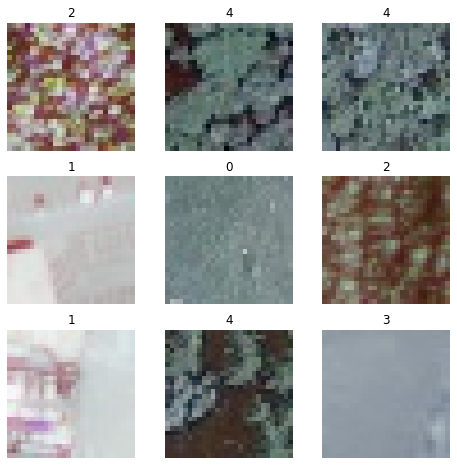

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [8]:
for image, label in train_ds.take(1):
    print(f'image shape: {image.shape}')
    print(f'label shape: {label.shape}')

image shape: (32, 28, 28, 3)
label shape: (32,)


In [9]:
train_labels, train_images = [], []
for image, label in tfds.as_numpy(train_ds):

    train_labels = np.append(train_labels, label)
    train_images.extend(image)
    

In [10]:
val_labels, val_images = [], []
for image, label in tfds.as_numpy(val_ds):

    val_labels = np.append(val_labels, label)
    val_images.extend(image)

In [17]:
train_images = np.array(train_images).astype('float32') / 255.
val_images = np.array(val_images).astype('float32') / 255.

In [54]:
val_labels = val_labels.astype(np.int64)
class_idx_to_test_idxs = defaultdict(list)
for y_test_idx, y in enumerate(val_labels):
    class_idx_to_test_idxs[y].append(y_test_idx)

In [55]:
val_labels

array([4, 1, 5, ..., 2, 4, 1])

## Autoencoder

In [19]:
class Autoencoder(Model):
  def __init__(self):
    super(Autoencoder, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Input(shape=(28, 28, 3)), 
      layers.Conv2D(16, (3,3), activation='relu', padding='same', strides=2),
      layers.Conv2D(8, (3,3), activation='relu', padding='same', strides=2)])

    self.decoder = tf.keras.Sequential([
      layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2D(1, kernel_size=(3,3), activation='sigmoid', padding='same')])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Autoencoder()

In [20]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [21]:
autoencoder.fit(train_images, train_images,
                epochs=10,
                shuffle=True,
                validation_data= (val_images, val_images))

Epoch 1/10
750/750 [==============================] - 27s 35ms/step - loss: 0.0157 - val_loss: 0.0043
Epoch 2/10
750/750 [==============================] - 26s 34ms/step - loss: 0.0042 - val_loss: 0.0038
Epoch 3/10
750/750 [==============================] - 26s 35ms/step - loss: 0.0037 - val_loss: 0.0036
Epoch 4/10
750/750 [==============================] - 26s 35ms/step - loss: 0.0036 - val_loss: 0.0035
Epoch 5/10
750/750 [==============================] - 26s 35ms/step - loss: 0.0035 - val_loss: 0.0033
Epoch 6/10
750/750 [==============================] - 26s 35ms/step - loss: 0.0033 - val_loss: 0.0033
Epoch 7/10
750/750 [==============================] - 27s 35ms/step - loss: 0.0033 - val_loss: 0.0032
Epoch 8/10
750/750 [==============================] - 26s 35ms/step - loss: 0.0032 - val_loss: 0.0032
Epoch 9/10
750/750 [==============================] - 26s 35ms/step - loss: 0.0032 - val_loss: 0.0032
Epoch 10/10
750/750 [==============================] - 27s 36ms/step - loss: 0.003

In [22]:
autoencoder.encoder.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 14, 14, 16)        448       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 8)           1160      
Total params: 1,608
Trainable params: 1,608
Non-trainable params: 0
_________________________________________________________________


In [23]:
autoencoder.decoder.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_transpose_2 (Conv2DTr (None, 14, 14, 8)         584       
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 28, 28, 16)        1168      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 1)         145       
Total params: 1,897
Trainable params: 1,897
Non-trainable params: 0
_________________________________________________________________


In [24]:
embeddings = autoencoder.encoder(val_images).numpy()

In [25]:
embeddings.shape

(5999, 7, 7, 8)

In [26]:
def similar_images(num_images,  test_index, test_dataset, metric = "euclidean"):
    image_tensor = test_dataset[test_index]
    tmp = np.delete(test_dataset, test_index, 0)
    knn = NearestNeighbors(n_neighbors=10, metric=metric)
    knn.fit(tmp)
    _, indices = knn.kneighbors(np.array([image_tensor]))
    return indices

In [27]:
num_classes, height_width = 6, 28
num_collage_examples, near_neighbors_per_example = 5, 10
examples = np.empty(
    (
        num_collage_examples,
        near_neighbors_per_example + 1,
        height_width,
        height_width,
        3,
    ),
    dtype = np.float32
)

In [28]:
val_x = embeddings.reshape((embeddings.shape[0], -1))

In [29]:
for row_idx in range(num_collage_examples):
    examples[row_idx, 0] = val_images[row_idx]
    anchor_near_neighbors = similar_images(near_neighbors_per_example, row_idx, val_x)
    tmp = anchor_near_neighbors.tolist()[0] 

    for col_idx, nn_idx in enumerate(tmp):
        examples[row_idx, col_idx+1] = val_images[nn_idx]

In [30]:
def show_collage(exxamples):
    box_size = height_width + 2
    num_rows, num_cols = examples.shape[:2]
    collage = Image.new(
        mode="RGB",
        size=(num_cols * box_size, num_rows *box_size),
        color=(250, 250, 250),
    )
    for row_idx in range(num_rows):
        for col_idx in range(num_cols):
            array = (np.array(examples[row_idx, col_idx]) * 255).astype(np.uint8)
            collage.paste(
                Image.fromarray(array), (col_idx*box_size, row_idx * box_size)
            )
    collage = collage.resize((4*num_cols*box_size, 4 *num_rows *box_size))
    
    return collage

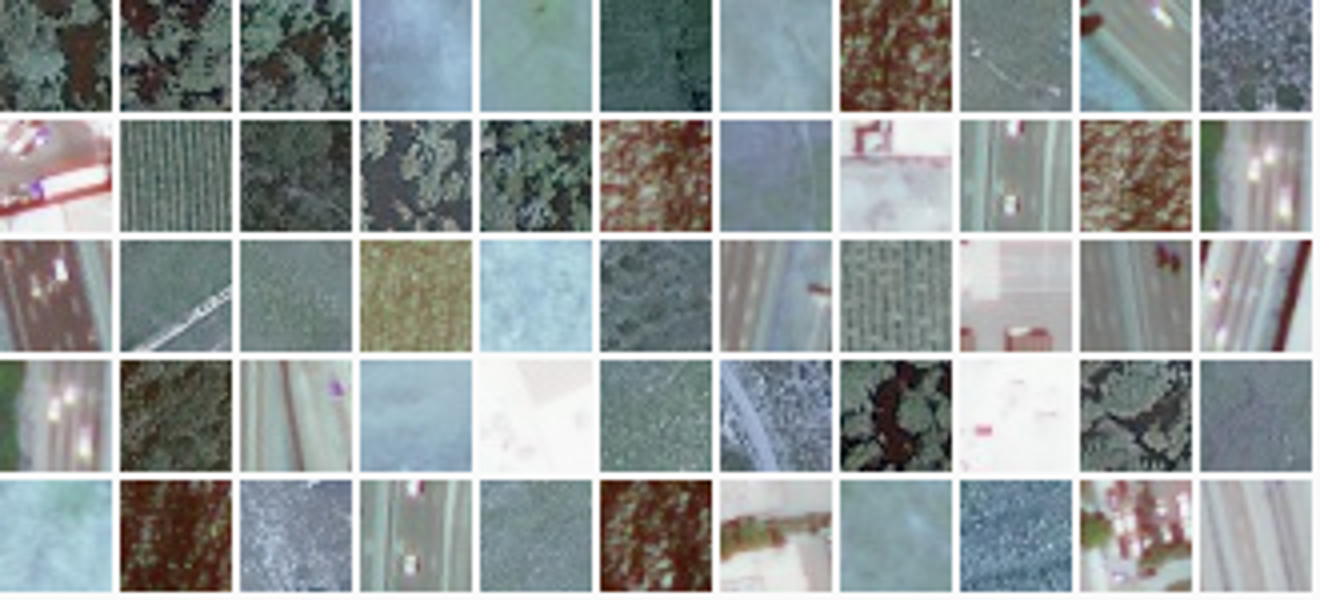

In [31]:
show_collage(examples)

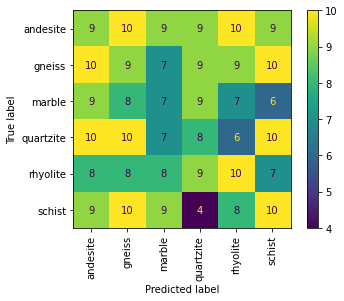

In [57]:
confusion_matrix = np.zeros((num_classes, num_classes))
# For each class.
for class_idx in range(num_classes):
    # Consider 10 examples.
    example_idxs = class_idx_to_test_idxs[class_idx][:10]
    for y_test_idx in example_idxs:
        anchor_near_neighbors = similar_images(near_neighbors_per_example, y_test_idx,val_x)
        for nn_idx in anchor_near_neighbors:
            nn_class_idx = val_labels[nn_idx]
#             print(class_idx, nn_class_idx)
            confusion_matrix[class_idx, nn_class_idx] += 1
labels = [
    "andesite",
    "gneiss",
    "marble",
    "quartzite",
    "rhyolite",
    "schist",
]
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=labels)
disp.plot(include_values=True, cmap="viridis", ax=None, xticks_rotation="vertical")
plt.show()